# Planning Methods: Part II, Spring 2023

# Lab 5: Logistic Regressions

**About This Lab**
* This lab uses the following file in the same directory with this notebook:
    * `clean_property_data.csv`
* This data includes properties that were sold through a real estate site (like Zillow) between 2001 and 2006 in Bogota. There are apartments and houses, characteristics of the structure like area and bathrooms, and characteristics of the neighborhood like density and a proxy for neighborhood income which is called SES.

## Objectives

You will also learn how to:
>1. Run a logistic regression
>2. Analyze odds ratios
>3. Plot predicted probabilities

## 1 Import packages, load & clean data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.discrete_model import Logit  

In [2]:
raw = pd.read_csv('clean_property_data.csv')

# create subdataframe
var_list = ['price_000','pop_dens','ses','house','area_m2','num_bath','pcn_green','thefts', 'year']
data = raw[var_list].copy()
data.head()

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,thefts,year
0,60000,830.78,4,0,70,2,1.74,39.92,2001
1,140000,826.75,4,1,257,4,0.54,46.00,2002
2,38000,914.15,4,0,115,4,1.55,45.87,2002
3,110000,911.25,4,1,270,4,1.58,45.88,2002
4,120000,757.37,4,1,268,2,0.40,46.00,2002


### Recode variables

In [3]:
# create SES dv
data['high_ses'] = np.where(data['ses']>=5, 1, 0)

Now, let's create dummy variables for the year the property was sold. There are 6 unique years, and we can create a new dummy column for each year. This could be a long process, but python can make this easier for us!

In [4]:
# look at the unique values in the 'year' variable
data['year'].unique()

array([2001, 2002, 2004, 2003, 2005, 2006])

In [5]:
# create dummies from categorical variable year
dummies = pd.get_dummies(data['year'], prefix = 'yr') 
dummies.head()

,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [6]:
# append the dummies to our larger dataframe
data = pd.concat([data, dummies], axis = 1)
data.head()

,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,thefts,year,high_ses,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006
0,60000,830.78,4,0,70,2,1.74,39.92,2001,0,1,0,0,0,0,0
1,140000,826.75,4,1,257,4,0.54,46.00,2002,0,0,1,0,0,0,0
2,38000,914.15,4,0,115,4,1.55,45.87,2002,0,0,1,0,0,0,0
3,110000,911.25,4,1,270,4,1.58,45.88,2002,0,0,1,0,0,0,0
4,120000,757.37,4,1,268,2,0.40,46.00,2002,0,0,1,0,0,0,0


## 2 Robust errors in multivariable regression
One way to mitigate the impacts of heteroskedasticity is to use
robust errors. Remember from last lab and class what heteroskedasticity is: the errors are not uniformly distributed around a line of slope zero. A consequence of heteroskedasticity is that the standard errors you estimate commonly can be unusually small and hence you may inappropriately reject or accept a null hypothesis that the coefficient is zero. Hence the use of robust errors, which isn't required but simply an option to mitigate this problem if it is present.

### 2.1 Without robust errors

In [7]:
# define independent variables
ind_var = ['high_ses', 'house', 'area_m2', 'num_bath', 'pcn_green', 
           'thefts','yr_2002','yr_2003','yr_2004','yr_2005','yr_2006'] 
# note that the year variable is categorical so we need to exclude one to prevent collinearity 
# within our model - we will exclude year 2001 - we chose to have the earlier year be our base year

x = data[ind_var].assign(Intercept = 1) # independent variables
y = data['price_000'] # dependent variable

model = sm.OLS(y, x).fit()
# save the results as "model" - this will be useful for other functions below.

model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.526     
Dependent Variable:   price_000         AIC:                 97643.6615
Date:                 2023-02-17 22:47  BIC:                 97719.1179
No. Observations:     3976              Log-Likelihood:      -48810.   
Df Model:             11                F-statistic:         402.2     
Df Residuals:         3964              Prob (F-statistic):  0.00      
R-squared:            0.527             Scale:               2.7023e+09
-----------------------------------------------------------------------
             Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------
high_ses   72215.4064 3151.9478  22.9114 0.0000  66035.8154  78394.9973
house     -25760.7177 2439.5596 -10.5596 0.0000 -30543.6271 -20977.8084
area_m2      566.9380   14.3065  39.6279 0.0000    538.8891    594.9868
num_bath   10559.7664  957.8052  11.0250 0.0000   8681.9293  12437.6035
pcn_green    161.1475  115.4937   1.3953 0.1630    -65.2851    387.5801
thefts       -24.0329   16.0238  -1.4998 0.1337    -55.4485      7.3827
yr_2002     -265.7563 3186.9542  -0.0834 0.9335  -6513.9796   5982.4670
yr_2003     8079.4845 3055.2693   2.6444 0.0082   2089.4377  14069.5314
yr_2004     8448.0953 2749.0138   3.0731 0.0021   3058.4817  13837.7090
yr_2005    18176.6143 2862.9095   6.3490 0.0000  12563.7010  23789.5276
yr_2006    23245.8901 3213.0725   7.2348 0.0000  16946.4602  29545.3200
Intercept  -4589.4649 3273.0502  -1.4022 0.1609 -11006.4848   1827.5550
-----------------------------------------------------------------------
Omnibus:              3155.431       Durbin-Watson:          0.919     
Prob(Omnibus):        0.000          Jarque-Bera (JB):       130563.264
Skew:                 3.445          Prob(JB):               0.000     
Kurtosis:             30.215         Condition No.:          1182      
=======================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

### 2.2 With robust errors
Take a look at the output - what's changed? What's stayed the same?

In [8]:
model = sm.OLS(y, x).fit(cov_type='HC0') ##cov_type='HC0' introduces robust errors
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:               OLS               Adj. R-squared:      0.526     
Dependent Variable:  price_000         AIC:                 97643.6615
Date:                2023-02-17 22:47  BIC:                 97719.1179
No. Observations:    3976              Log-Likelihood:      -48810.   
Df Model:            11                F-statistic:         161.8     
Df Residuals:        3964              Prob (F-statistic):  4.65e-309 
R-squared:           0.527             Scale:               2.7023e+09
----------------------------------------------------------------------
             Coef.     Std.Err.    z    P>|z|     [0.025      0.975]  
----------------------------------------------------------------------
high_ses   72215.4064 5411.1596 13.3456 0.0000  61609.7284  82821.0843
house     -25760.7177 3681.9910 -6.9964 0.0000 -32977.2875 -18544.1479
area_m2      566.9380   28.2499 20.0687 0.0000    511.5692    622.3067
num_bath   10559.7664 1101.9093  9.5832 0.0000   8400.0639  12719.4689
pcn_green    161.1475   77.5774  2.0772 0.0378      9.0986    313.1964
thefts       -24.0329   18.8510 -1.2749 0.2024    -60.9802     12.9145
yr_2002     -265.7563 3123.5738 -0.0851 0.9322  -6387.8485   5856.3359
yr_2003     8079.4845 3098.4411  2.6076 0.0091   2006.6516  14152.3174
yr_2004     8448.0953 2612.2143  3.2341 0.0012   3328.2494  13567.9412
yr_2005    18176.6143 2928.9030  6.2059 0.0000  12436.0699  23917.1587
yr_2006    23245.8901 3088.6739  7.5262 0.0000  17192.2004  29299.5798
Intercept  -4589.4649 3750.3703 -1.2237 0.2211 -11940.0556   2761.1258
----------------------------------------------------------------------
Omnibus:             3155.431       Durbin-Watson:          0.919     
Prob(Omnibus):       0.000          Jarque-Bera (JB):       130563.264
Skew:                3.445          Prob(JB):               0.000     
Kurtosis:            30.215         Condition No.:          1182      
======================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

## 3 Logistic regression (aka logit model)

Remember - logistic regressions are used when the **dependent** variable is a dummy variable (0 or 1). In this case, we are going to transform our price into a dummy variable, using the median as cutoff.

### 3.1 Create dependent variable

In [9]:
# identify dummy threshold
price_median = data['price_000'].median()
print(price_median)

# create dummy dependent variable
data['high_price'] = np.where(data['price_000']>price_median, 1, 0)
data.head()

72000.0


,price_000,pop_dens,ses,house,area_m2,num_bath,pcn_green,thefts,year,high_ses,yr_2001,yr_2002,yr_2003,yr_2004,yr_2005,yr_2006,high_price
0,60000,830.78,4,0,70,2,1.74,39.92,2001,0,1,0,0,0,0,0,0
1,140000,826.75,4,1,257,4,0.54,46.00,2002,0,0,1,0,0,0,0,1
2,38000,914.15,4,0,115,4,1.55,45.87,2002,0,0,1,0,0,0,0,0
3,110000,911.25,4,1,270,4,1.58,45.88,2002,0,0,1,0,0,0,0,1
4,120000,757.37,4,1,268,2,0.40,46.00,2002,0,0,1,0,0,0,0,1


### 3.2 Run logit model

In [10]:
y = data['high_price'] # dependent variable - it's a dummy!
x = data[ind_var].assign(Intercept = 1) # independent variables - same list as before

# define and run logit model
logit_model = Logit(y, x).fit()
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.410658
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.408    
Dependent Variable: high_price       AIC:              3289.5511
Date:               2023-02-17 22:47 BIC:              3365.0074
No. Observations:   3976             Log-Likelihood:   -1632.8  
Df Model:           11               LL-Null:          -2755.8  
Df Residuals:       3964             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
high_ses     1.7720    0.1970    8.9932  0.0000   1.3858   2.1582
house       -0.3467    0.1312   -2.6433  0.0082  -0.6039  -0.0896
area_m2      0.0289    0.0014   20.8734  0.0000   0.0262   0.0316
num_bath     0.6346    0.0571   11.1054  0.0000   0.5226   0.7465
pcn_green    0.0426    0.0056    7.5450  0.0000   0.0315   0.0537
thefts      -0.0059    0.0009   -6.2730  0.0000  -0.0077  -0.0041
yr_2002     -0.1936    0.1786   -1.0842  0.2783  -0.5436   0.1564
yr_2003      0.5769    0.1704    3.3855  0.0007   0.2429   0.9108
yr_2004      0.5040    0.1507    3.3441  0.0008   0.2086   0.7995
yr_2005      0.9488    0.1555    6.1027  0.0000   0.6441   1.2535
yr_2006      1.5429    0.1697    9.0942  0.0000   1.2103   1.8754
Intercept   -4.6274    0.2231  -20.7368  0.0000  -5.0647  -4.1900
================================================================

"""

### 3.3 Display odds ratios

In [11]:
# odds ratios
or_table = np.exp(logit_model.conf_int()) # exponentiate confidence intervals
or_table['Odds Ratio'] = np.exp(logit_model.params) # exponentiate coefficients

or_table.columns = ['2.5%', '97.5%', 'Odds Ratio'] # name columns
or_table

,2.5%,97.5%,Odds Ratio
high_ses,3.998069,8.655421,5.882599
house,0.546701,0.914263,0.706985
area_m2,1.026550,1.032140,1.029341
num_bath,1.686351,2.109708,1.886189
pcn_green,1.032034,1.055128,1.043517
thefts,0.992298,0.995958,0.994126
yr_2002,0.580653,1.169267,0.823977
yr_2003,1.274952,2.486408,1.780463
yr_2004,1.231980,2.224358,1.655405
yr_2005,1.904214,3.502556,2.582560


## 4 Plot predicted probabilities

In [12]:
data['num_bath'].unique()

array([2, 4, 3, 1, 5])

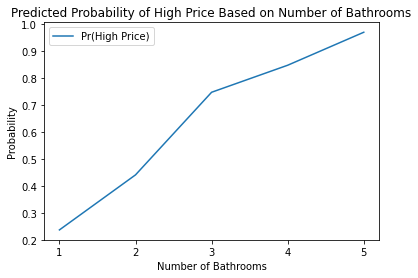

In [13]:
# predicted probabilities
df_predict = data.copy()
df_predict['pred_high_price'] = logit_model.predict(x)

# plot probabilities by key independent variable
df_predict2 = df_predict.groupby(by = 'num_bath').agg(np.mean)[['pred_high_price']]
df_predict2.plot();

# plot with labels
plt.title('Predicted Probability of High Price Based on Number of Bathrooms')
plt.xlabel('Number of Bathrooms'),
plt.ylabel('Probability'),
positions = (1, 2, 3, 4, 5)
labels = ('1', '2', '3', '4', '5')
plt.xticks(positions, labels)
legend = ['Pr(High Price)']
plt.legend(legend);